Build emulator for the SVD components of $\{ P_0(k | \theta_i) \}_{i \in LHD}$ 

In [1]:
import numpy as np 
import scipy as sp
import george as George

# -- local -- 
import env
from specmulator import emulator as Emu
from specmulator import onlyhod as onlyHOD

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Lets begin by reading in $\{\theta_i\}^{LHD}$s of the Latin Hypercube Design, which will be used to train the GP.

In [3]:
theta_lhd = onlyHOD.HOD_LHD(prior='sinha2017prior_narrow', samples=40, method='mdu')
keylist = ['$\log\,M_{min}$', '$\sigma_{\log M}$', '$\log M_0$', '$\log M_1$', '\alpha']
print keylist
print theta_lhd[:5,:]
print theta_lhd.shape

['$\\log\\,M_{min}$', '$\\sigma_{\\log M}$', '$\\log M_0$', '$\\log M_1$', '\x07lpha']
[[11.725554  0.014474  8.357269 13.744437  1.245645]
 [11.046257  0.645123  9.217882 12.197783  1.003222]
 [11.626188  0.183786 10.483516 12.093106  1.158378]
 [11.891967  0.491157 12.775824 13.190476  0.968588]
 [12.074197  0.772377 10.988946 12.732762  0.779019]]
(39, 5)


Read in multiple realizations of $\{P(k|\theta_i)\}_{i\in LHD}$ 

In [4]:
pk_lhd = [] 
for ireal in range(1,11): 
    k_arr, pk_lhd_i = onlyHOD.X_HODLHD(ireal, obvs='pk',
                          ell=0, Nmesh=360, rsd=True, karr=True,
                          prior='sinha2017prior_narrow', samples=40, method='mdu', silent=True)
    pk_lhd.append(pk_lhd_i)
pk_lhd = np.mean(np.array(pk_lhd), axis=0)

Here's what $\{P(k|\theta_i)\}_{i\in LHD}$ look like

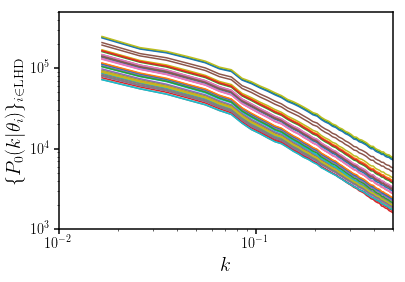

In [5]:
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(pk_lhd.shape[0]): 
    sub.plot(k_arr, pk_lhd[i,:])
sub.set_xlabel(r'$k$', fontsize=20)
sub.set_xlim([0.01, 0.5])
sub.set_xscale('log')
sub.set_ylabel(r'$\{P_0(k|\theta_i)\}_{i \in \mathrm{LHD}}$', fontsize=20)
sub.set_ylim([10**3, 5e5])
sub.set_yscale('log')

Now lets construct $\{\theta_i\}^{test}$ which we will use for testing the accuracy of the GP.

In [6]:
theta_test = onlyHOD.testHOD_LHD(prior='sinha2017prior_narrow', samples=20)
print keylist
print theta_test[:5,:]
print theta_test.shape

['$\\log\\,M_{min}$', '$\\sigma_{\\log M}$', '$\\log M_0$', '$\\log M_1$', '\x07lpha']
[[11.394737  0.645092  8.842105 13.026316  1.144737]
 [11.805263  0.461066  8.421053 13.236842  1.197368]
 [11.489474  0.671382 11.789474 12.763158  0.776316]
 [11.615789  0.329618 10.526316 12.815789  1.171053]
 [11.363158  0.75025  10.315789 13.447368  1.118421]]
(20, 5)


Text(0,0.5,'$\\sigma_{\\log M}$')

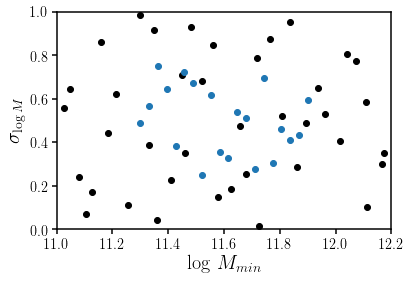

In [7]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.scatter(theta_lhd[:,0], theta_lhd[:,1], c='k')
sub.scatter(theta_test[:,0], theta_test[:,1])
sub.set_xlim([11.0, 12.2])
sub.set_xlabel(keylist[0], fontsize=20)
sub.set_ylim([0., 1.])
sub.set_ylabel(keylist[1], fontsize=20)

$\{P(k|\theta_i)\}^{test}$

In [8]:
pk_test = [] 
for ireal in range(1,11): 
    k_arr, pk_test_i = onlyHOD.X_testHODLHD(ireal, obvs='pk',
                          ell=0, Nmesh=360, rsd=True, karr=True,
                          prior='sinha2017prior_narrow', samples=20, silent=True)
    pk_test.append(pk_test_i)
pk_test = np.mean(np.array(pk_test), axis=0)

Here's what $\{P(k|\theta_i)\}_{test}$ look like

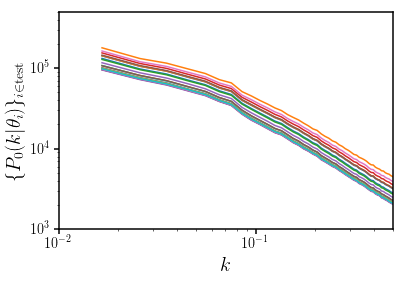

In [9]:
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(pk_test.shape[0]): 
    sub.plot(k_arr, pk_test[i,:])
sub.set_xlabel(r'$k$', fontsize=20)
sub.set_xlim([0.01, 0.5])
sub.set_xscale('log')
sub.set_ylabel(r'$\{P_0(k|\theta_i)\}_{i \in \mathrm{test}}$', fontsize=20)
sub.set_ylim([10**3, 5e5])
sub.set_yscale('log')

Get the SVD components of the LHD.

In [23]:
n_comp = 10
svd_lhd = Emu.Svd(pk_lhd, n_comp=n_comp)

In [24]:
X_lhd = svd_lhd._white(pk_lhd)
X_test = svd_lhd._white(pk_test)

$\{P(k|\theta_i)\}_{i\in LHD}$ whitened by subtracting out the mean and scaling by the standard deviation

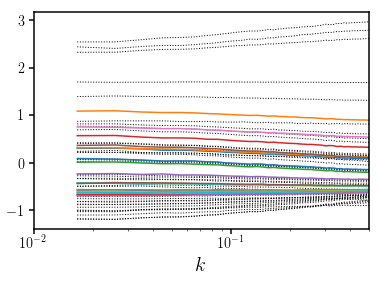

In [25]:
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(pk_lhd.shape[0]): 
    sub.plot(k_arr, X_lhd[i,:], c='k', lw=1, ls=':')
for i in range(pk_test.shape[0]): 
    sub.plot(k_arr, X_test[i,:])
sub.set_xlabel(r'$k$', fontsize=20)
sub.set_xlim([0.01, 0.5])
sub.set_xscale('log')

In [26]:
pc_lhd = svd_lhd.transform(pk_lhd)

In [27]:
pc_test = svd_lhd.transform(pk_test)

In [28]:
# explained variance
print svd_lhd.exp_var_ratio

[9.96039955e-01 3.33944841e-03 6.05698271e-04 1.03653791e-05
 1.74092973e-06 5.38772547e-07 3.42343548e-07 2.92506374e-07
 2.79215761e-07 1.70989336e-07]


Test SVD transformation

Text(0.5,1,'SVD check')

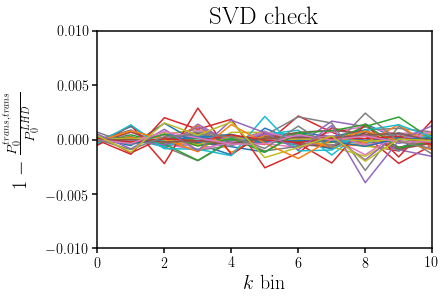

In [33]:
pc_lhd_inv = svd_lhd.inv_transform(pc_lhd)
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(pc_lhd_inv.shape[0]): 
    sub.plot(range(pc_lhd_inv.shape[1]), 1.-pc_lhd_inv[i,:]/pk_lhd[i,:])
sub.set_xlabel('$k$ bin', fontsize=20)
#sub.set_xscale('log')
sub.set_xlim([0, pc_lhd.shape[1]])
sub.set_ylabel(r'$1 - \frac{P_0^{trans,trans}}{P_0^{LHD}}$', fontsize=20)
sub.set_ylim([-0.01, 0.01])
sub.set_title("SVD check", fontsize=25)

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.


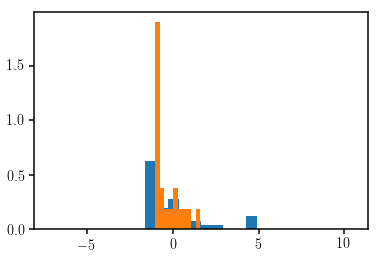

In [36]:
fig = plt.figure()
sub = fig.add_subplot(111)
_ = sub.hist(pc_lhd[:,0], color='C0', normed=True) # LHD
_ = sub.hist(pc_test[:,0], color='C1', normed=True) # test

In [37]:
def trainGP(X, Y): 
    # train GP for each dimension of Y -- i.e. treat each k value of P_0 as a separate component
    lguess = [(np.max(X[:,i]) - np.min(X[:,i]))/float(X.shape[0]) for i in range(X.shape[1])]

    gps = [] 
    for i in range(Y.shape[1]): 
        kernel = np.var(Y[:,i]) * George.kernels.ExpSquaredKernel(lguess, ndim=X.shape[1])
        gp = George.GP(kernel, mean=np.mean(Y[:,i]), fit_mean=True)
        gp.compute(X)
        gps.append(gp)
    return gps


def trainGP_opt(X, Y): 
    # train GP for each dimension of Y -- i.e. treat each k value of P_0 as a separate component
    lguess = [(np.max(X[:,i]) - np.min(X[:,i]))/float(X.shape[0]) for i in range(X.shape[1])]

    gps = [] 
    for i in range(Y.shape[1]): 
        kernel = np.var(Y[:,i]) * George.kernels.ExpSquaredKernel(lguess, ndim=X.shape[1])
        gp = George.GP(kernel, mean=np.mean(Y[:,i]), fit_mean=True)
        gp.compute(X)
        # optimize hyperparameters
        p0 = gp.get_parameter_vector()
        results = sp.optimize.minimize(gp.nll, p0, args=(Y[:,i]), jac=gp.grad_nll, method='L-BFGS-B')
        gp.set_parameter_vector(results.x)
        gps.append(gp)
    return gps

def emu(x_pred, gps, Y): 
    # use GPs to predict Plk at x_pred
    mus, vs = [], [] 
    for i, gp in enumerate(gps): 
        mu, var = gp.predict(Y[:,i], x_pred)
        mus.append(mu)
        vs.append(var)
    return np.array(mus).T, np.array(vs).T

In [49]:
# train Gaussian processes on the LHD
gp_emu = trainGP_opt(theta_lhd, pc_lhd)

In [50]:
# now evaluate at the test points
pc_test_pred, var_test_pred = emu(theta_test, gp_emu, pc_lhd)

(-2.0, 2.0)

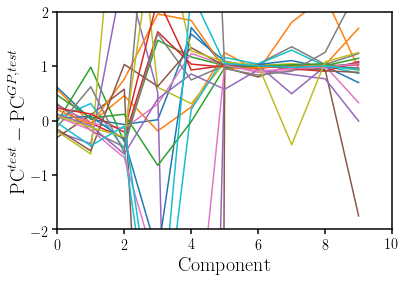

In [51]:
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(pc_test_pred.shape[0]): 
    sub.plot(range(pc_test_pred.shape[1]), 1.- pc_test_pred[i,:]/pc_test[i,:])
sub.set_xlabel('Component', fontsize=20)
sub.set_xlim([0., pc_test_pred.shape[1]])
sub.set_ylabel('$\mathrm{PC}^{test} - \mathrm{PC}^{GP,test}$', fontsize=20)
sub.set_ylim([-2., 2.])

In [52]:
pk_test_pred = svd_lhd.inv_transform(pc_test_pred)
pk_test_recon = svd_lhd.inv_transform(pc_test)

Text(0,0.5,'$P_0^{test} - P_0^{GP,test}$')

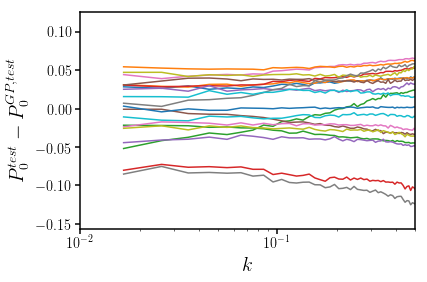

In [53]:
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(pk_test_pred.shape[0]): 
    sub.plot(k_arr, 1. - pk_test_pred[i,:]/pk_test[i,:])
sub.set_xlabel('$k$', fontsize=20)
sub.set_xscale('log')
sub.set_xlim([0.01,0.5])
sub.set_ylabel('$P_0^{test} - P_0^{GP,test}$', fontsize=20)

### Exclusion test
Train the GP on the LHD excluding one of the central $\theta_i$ and see how well it can predict $P_0(k|\theta_i)$

In [ ]:
inner = (theta_lhd[:,0] > t_min[0]) & (theta_lhd[:,0] < t_max[0])
for i in range(1, theta_lhd.shape[1]): 
    inner = inner & (theta_lhd[:,i] > t_min[i]) & (theta_lhd[:,i] < t_max[i])
print np.sum(inner)